In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical


In [15]:
# Paths to fire and non-fire image folders
fire_path = "D:/FireDetection/fireImages/fire_images"
non_fire_path = "D:/FireDetection/nonFireImages/non_fire_images"

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

# Load fire and non-fire images with labels
fire_images, fire_labels = load_images_from_folder(fire_path, 1)
non_fire_images, non_fire_labels = load_images_from_folder(non_fire_path, 0)

# Combine datasets
images = fire_images + non_fire_images
labels = fire_labels + non_fire_labels

In [16]:
print("Jumlah gambar dari folder api:", len(fire_images))
print("Jumlah gambar dari folder bukan api:", len(non_fire_images))
print("Total gambar yang dimuat:", len(images))
print("Total label yang dimuat:", len(labels))


Jumlah gambar dari folder api: 48
Jumlah gambar dari folder bukan api: 48
Total gambar yang dimuat: 96
Total label yang dimuat: 96


In [17]:
def get_color_histogram(image):
    histograms = []
    for i in range(3):  # For each color channel (B, G, R)
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        histograms.extend(hist.flatten())
    return histograms

def get_texture_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    return [contrast, dissimilarity, homogeneity, energy, correlation, asm]


In [18]:
data = []
for img, label in zip(images, labels):
    histogram_features = get_color_histogram(img)
    texture_features = get_texture_features(img)
    features = histogram_features + texture_features
    data.append(features + [label])

columns = [f'hist_{i}' for i in range(768)] + ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'asm', 'label']
df = pd.DataFrame(data, columns=columns)
df

,hist_0,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,hist_9,...,hist_765,hist_766,hist_767,contrast,dissimilarity,homogeneity,energy,correlation,asm,label
0,836.0,177.0,347.0,264.0,294.0,348.0,341.0,421.0,403.0,448.0,...,32.0,10.0,68.0,849.738942,18.666290,0.116628,0.013335,0.750135,0.000178,1
1,2315.0,436.0,568.0,769.0,1041.0,1194.0,1361.0,1610.0,1622.0,1735.0,...,171.0,175.0,1072.0,2536.091822,33.559836,0.060701,0.008886,0.670798,0.000079,1
2,6070.0,709.0,846.0,878.0,1008.0,1081.0,1231.0,1333.0,1481.0,1711.0,...,122.0,122.0,3065.0,964.723370,17.432679,0.117941,0.013215,0.750436,0.000175,1
3,964.0,133.0,155.0,161.0,192.0,218.0,255.0,297.0,351.0,429.0,...,162.0,160.0,2533.0,1825.704539,28.795197,0.060006,0.007601,0.741482,0.000058,1
4,91733.0,31849.0,27792.0,18938.0,12690.0,8565.0,6337.0,4714.0,3910.0,3465.0,...,4828.0,5409.0,24506.0,830.052548,14.595811,0.206883,0.016902,0.854654,0.000286,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,86.367769,5.978993,0.219739,0.024145,0.937008,0.000583,0
92,433.0,182.0,456.0,462.0,1121.0,2458.0,4039.0,5793.0,4861.0,8445.0,...,408.0,115.0,14.0,121.036092,5.026561,0.344610,0.026739,0.983563,0.000715,0
93,3.0,3.0,3.0,7.0,26.0,35.0,81.0,111.0,186.0,281.0,...,51.0,32.0,142.0,815.106754,15.683567,0.142875,0.012571,0.892474,0.000158,0
94,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,211.725974,8.539709,0.185260,0.042759,0.811056,0.001828,0


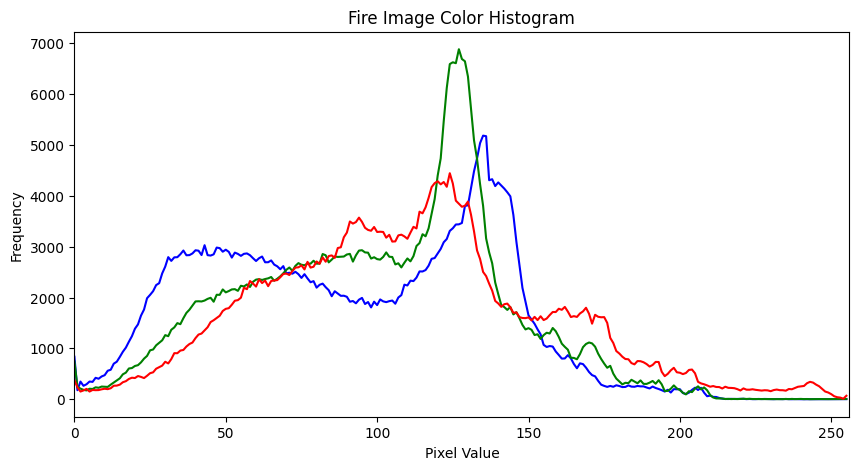

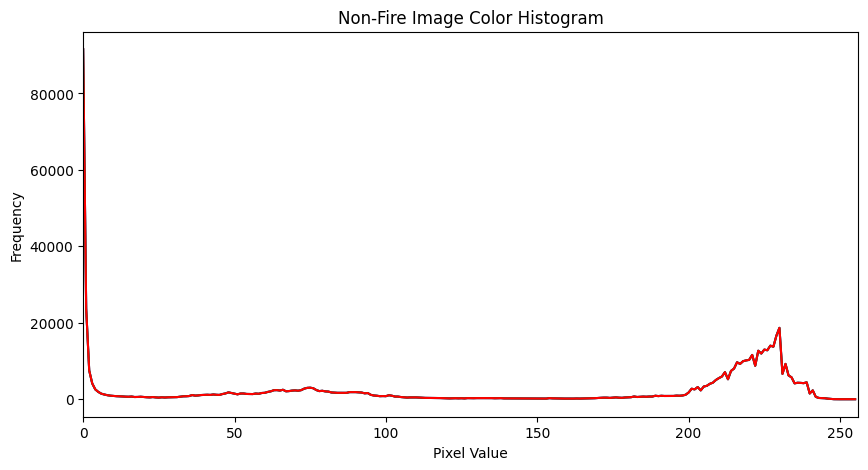

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_color_histogram(image, title="Color Histogram"):
    colors = ('b', 'g', 'r')
    plt.figure(figsize=(10, 5))
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

# Example usage:
plot_color_histogram(fire_images[0], title="Fire Image Color Histogram")
plot_color_histogram(non_fire_images[0], title="Non-Fire Image Color Histogram")


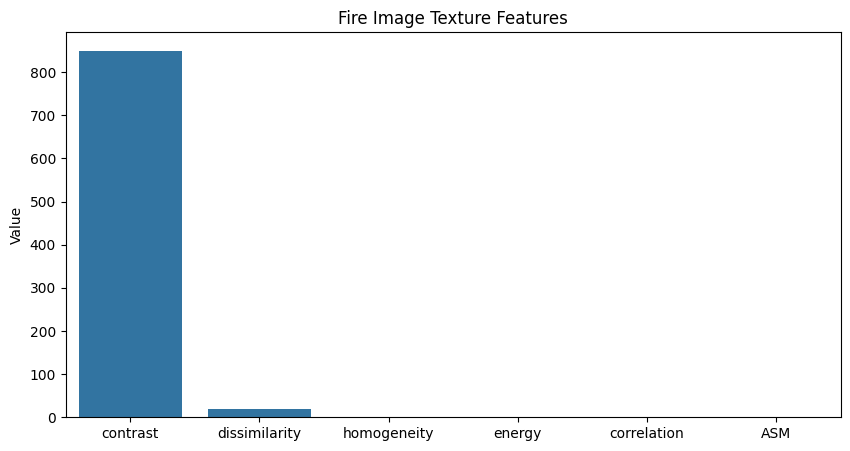

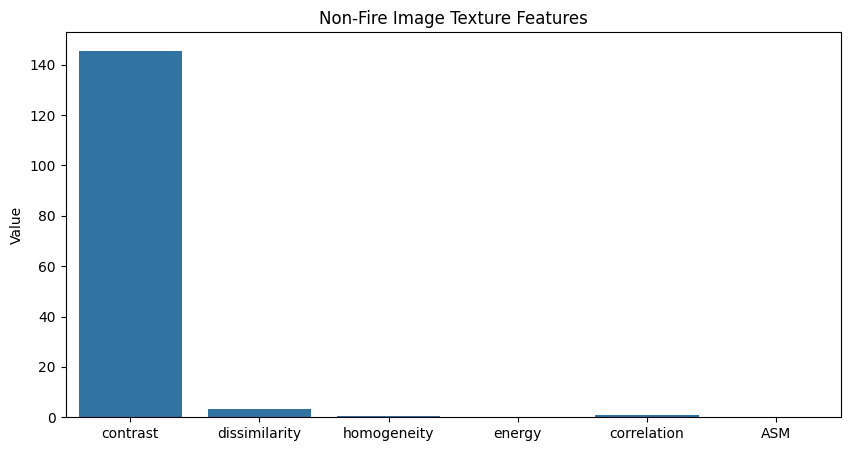

In [20]:
def plot_texture_features(image, title="Texture Features"):
    texture_features = get_texture_features(image)
    feature_names = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_names, y=texture_features)
    plt.title(title)
    plt.ylabel('Value')
    plt.show()

# Example usage:
plot_texture_features(fire_images[0], title="Fire Image Texture Features")
plot_texture_features(non_fire_images[0], title="Non-Fire Image Texture Features")


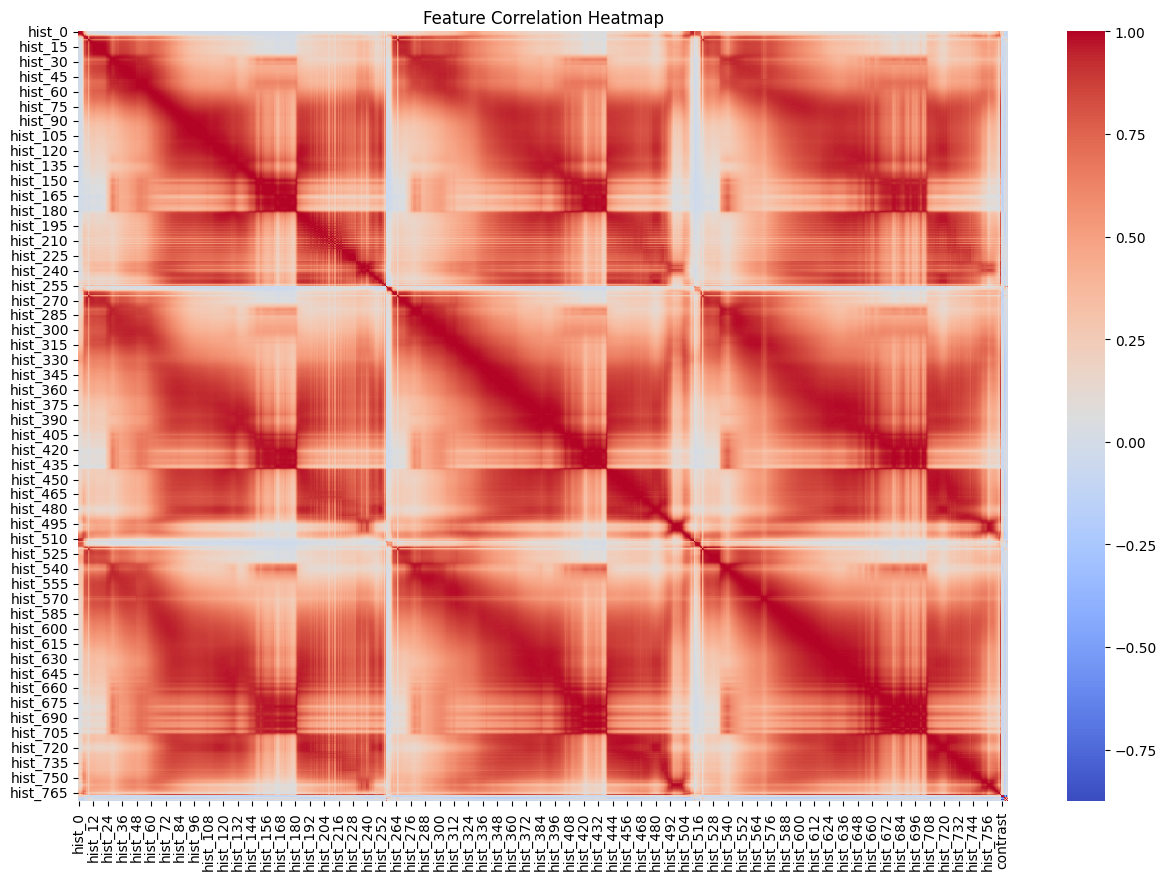

In [21]:
# Calculating correlation matrix for the features
correlation_matrix = df.drop('label', axis=1).corr()

# Plotting the heatmap for feature correlation
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()


In [22]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [24]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)

In [25]:
# Preprocess data for CNN
images_resized = [cv2.resize(img, (128, 128)) for img in images]
X = np.array(images_resized) / 255.0
y = to_categorical(labels, num_classes=2)

# Split data
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CNN model
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test_cnn))
cnn_preds = np.argmax(cnn.predict(X_test_cnn), axis=1)


c:\Users\ASUS VivoBook\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 938ms/step - accuracy: 0.4348 - loss: 0.7083 - val_accuracy: 0.5500 - val_loss: 0.5991
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 800ms/step - accuracy: 0.5892 - loss: 0.6396 - val_accuracy: 0.7000 - val_loss: 0.5883
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.7397 - loss: 0.5172 - val_accuracy: 0.6500 - val_loss: 0.5283
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 0.7449 - loss: 0.5292 - val_accuracy: 0.8500 - val_loss: 0.3074
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.8363 - loss: 0.3302 - val_accuracy: 0.7000 - val_loss: 0.3921
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.8627 - loss: 0.4319 - val_accuracy: 0.7500 - val_loss: 0.3868
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.8678 - loss: 0.3203 - val_accuracy: 1.0000 - val_loss: 0.2833
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step - accuracy: 0.9554 - loss: 0.2371 - val_accuracy: 1.0000 - val_loss:

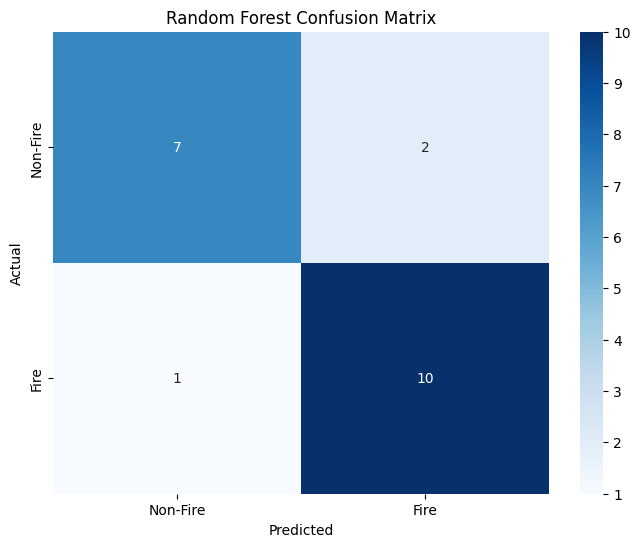

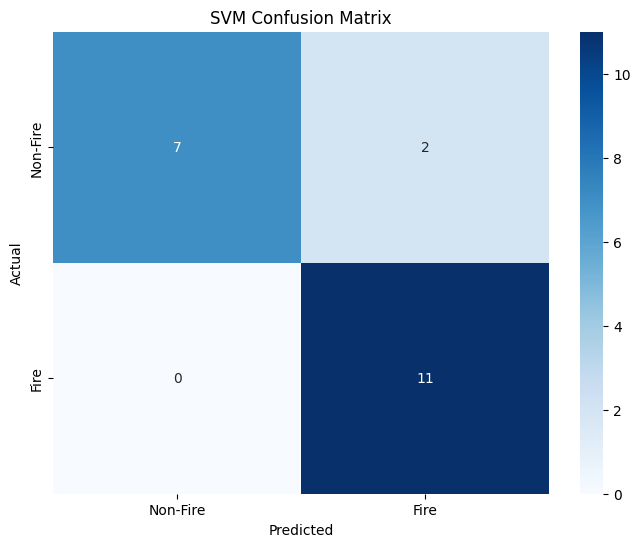

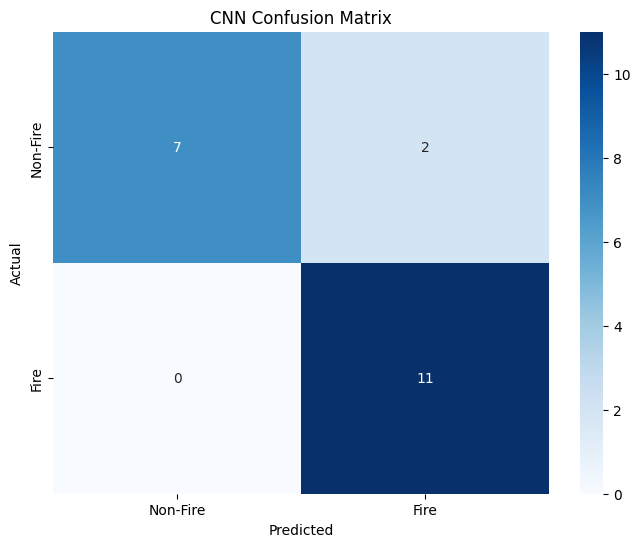

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix', labels=['Non-Fire', 'Fire']):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Compute confusion matrices
rf_cm = confusion_matrix(y_test, rf_preds)
svm_cm = confusion_matrix(y_test, svm_preds)
cnn_cm = confusion_matrix(np.argmax(y_test_cnn, axis=1), cnn_preds)

# Plot confusion matrices
plot_confusion_matrix(rf_cm, title='Random Forest Confusion Matrix')
plot_confusion_matrix(svm_cm, title='SVM Confusion Matrix')
plot_confusion_matrix(cnn_cm, title='CNN Confusion Matrix')



In [27]:
rf_cr = classification_report(y_test, rf_preds)
svm_cr = classification_report(y_test, svm_preds)
cnn_cr = classification_report(np.argmax(y_test_cnn, axis=1), cnn_preds)

print("Random Forest Classification Report:\n", rf_cr)
print("SVM Classification Report:\n", svm_cr)
print("CNN Classification Report:\n", cnn_cr)


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.83      0.91      0.87        11

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20

SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.85      1.00      0.92        11

    accuracy                           0.90        20
   macro avg       0.92      0.89      0.90        20
weighted avg       0.92      0.90      0.90        20

CNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.85      1.00      0.92        11

    accuracy                           0.90        20
   macro avg       0.92      0.89 

In [29]:
import pickle
import joblib
from keras.models import load_model

# Assuming rf, svm, and cnn are the trained models

# Save models
# Save Random Forest and SVM models using pickle
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf, file)

with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm, file)

# Save Random Forest and SVM models using joblib
joblib.dump(rf, 'rf_model.joblib')
joblib.dump(svm, 'svm_model.joblib')

# Save CNN model using Keras' built-in method
cnn.save('cnn_model.h5')

# Load models
# Load Random Forest and SVM models using pickle
with open('rf_model.pkl', 'rb') as file:
    rf_loaded = pickle.load(file)

with open('svm_model.pkl', 'rb') as file:
    svm_loaded = pickle.load(file)

# Load Random Forest and SVM models using joblib
rf_loaded_joblib = joblib.load('rf_model.joblib')
svm_loaded_joblib = joblib.load('svm_model.joblib')

# Load CNN model using Keras' built-in method
cnn_loaded = load_model('cnn_model.h5')


In [33]:
def predict_new_image(image_path, rf_model, svm_model, cnn_model):
    img = cv2.imread(image_path)
    if img is None:
        return "Image not found"

    img_resized = cv2.resize(img, (128, 128))
    img_array = np.expand_dims(img_resized, axis=0) / 255.0

    histogram_features = get_color_histogram(img)
    texture_features = get_texture_features(img)
    features = np.array(histogram_features + texture_features).reshape(1, -1)

    rf_pred = rf_model.predict(features)[0]
    svm_pred = svm_model.predict(features)[0]
    cnn_pred = np.argmax(cnn_model.predict(img_array), axis=1)[0]

    return rf_pred, svm_pred, cnn_pred

# Example usage:
new_image_path = 'D:/FireDetection/dataTest/data_test/data_test_fire/fire.70.png'
rf_result, svm_result, cnn_result = predict_new_image(new_image_path, rf, svm, cnn)
print(f"Random Forest Prediction: {'Fire' if rf_result == 1 else 'Non-Fire'}")
print(f"SVM Prediction: {'Fire' if svm_result == 1 else 'Non-Fire'}")
print(f"CNN Prediction: {'Fire' if cnn_result == 1 else 'Non-Fire'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Random Forest Prediction: Fire
SVM Prediction: Non-Fire
CNN Prediction: Fire


c:\Users\ASUS VivoBook\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\ASUS VivoBook\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Users\ASUS VivoBook\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\ASUS VivoBook\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


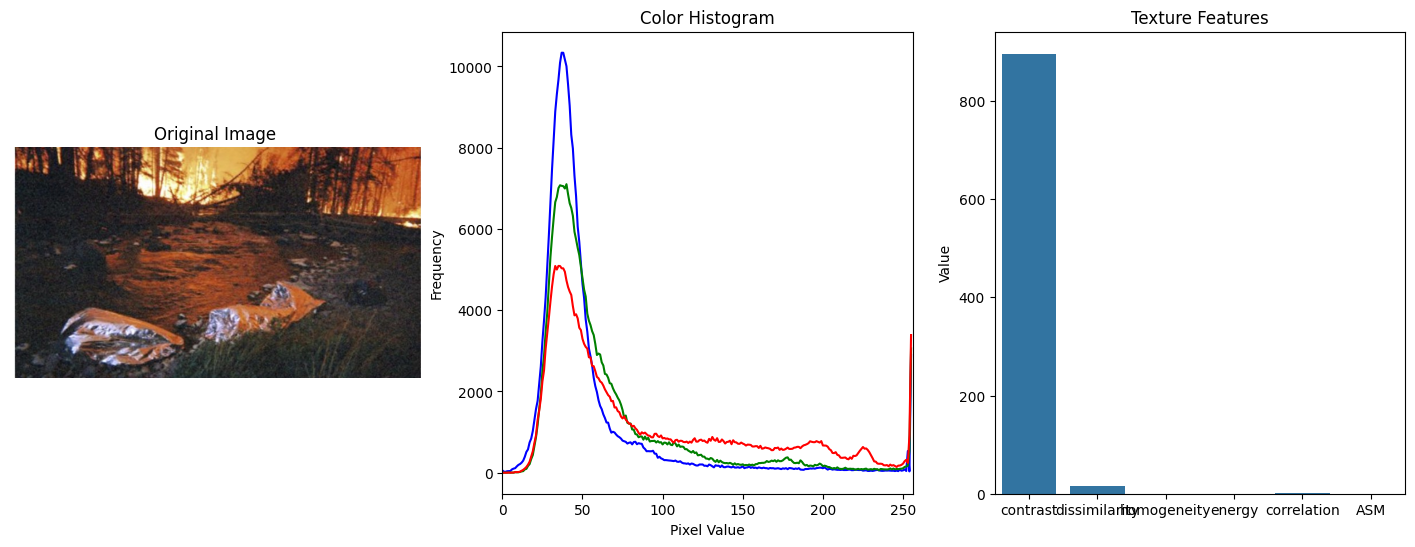

Random Forest Prediction: Fire
SVM Prediction: Non-Fire
CNN Prediction: Fire


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

def plot_color_histogram(image, ax, title="Color Histogram"):
    colors = ('b', 'g', 'r')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        ax.plot(hist, color=color)
    ax.set_xlim([0, 256])
    ax.set_title(title)
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Frequency')

def plot_texture_features(image, ax, title="Texture Features"):
    texture_features = get_texture_features(image)
    feature_names = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    sns.barplot(x=feature_names, y=texture_features, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Value')

def visualize_image_processing(image_path, rf_model, svm_model, cnn_model):
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found")
        return

    img_resized = cv2.resize(img, (128, 128))
    img_array = np.expand_dims(img_resized, axis=0) / 255.0

    histogram_features = get_color_histogram(img)
    texture_features = get_texture_features(img)
    features = np.array(histogram_features + texture_features).reshape(1, -1)

    rf_pred = rf_model.predict(features)[0]
    svm_pred = svm_model.predict(features)[0]
    cnn_pred = np.argmax(cnn_model.predict(img_array), axis=1)[0]

    # Plot original image
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Plot color histogram
    plot_color_histogram(img, axes[1], title="Color Histogram")

    # Plot texture features
    plot_texture_features(img, axes[2], title="Texture Features")

    plt.show()

    # Print predictions
    print(f"Random Forest Prediction: {'Fire' if rf_pred == 1 else 'Non-Fire'}")
    print(f"SVM Prediction: {'Fire' if svm_pred == 1 else 'Non-Fire'}")
    print(f"CNN Prediction: {'Fire' if cnn_pred == 1 else 'Non-Fire'}")

# Example usage:
new_image_path = 'D:/FireDetection/dataTest/data_test/data_test_fire/fire.70.png'
visualize_image_processing(new_image_path, rf, svm, cnn)
